In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [120]:
v0           = 2.0      # velocity
lambda_c = 1.5
lambda_a= 0.3
lambda_a_obstacle = 0.7
lambda_m = 0.5
r_n = 3
r_o = 10
eta          = 0.5      # random fluctuation in angle (in radians)
L            = 10       # size of box
R            = 1        # interaction radius
Rsq          = R**2     # square of the interaction radius
dt           = 0.2      # time step
Nt           = 80       # number of time steps
N            = 300     # number of birds
M = 10 # no of obstacles

In [3]:
def initialize_birds(N,L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N,1)*L
    y = np.random.rand(N,1)*L

    # bird velocities
    theta = 2 * np.pi * np.random.rand(N,1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [4]:
def initialize_obstacles(M,L):
    x = np.random.rand(M,1)*L
    y = np.random.rand(M,1)*L
    
    return x,y

In [5]:
x_o, y_o = initialize_obstacles(M,L)

In [37]:
def dead_bird(x,y,x_o, y_o):
    
    k = 0
    for bird in range(N):
        croppers = (x_o-x[bird])**2+(y_o-y[bird])**2 < 0.01
        k += sum(croppers)[0]
        
    return k

In [7]:
def apply_boundary_conditions(x,y,L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

In [8]:
def update_positions(x,y,xv,vy,dt,L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

In [148]:
def centre_of_mass(x, y, lambda_c, R):
    # define neighbours birds can see
    
    vx_c=np.zeros_like(x)
    vy_c=np.zeros_like(y)
    
    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < R**2 # find neighbours x_j within R
        boundary_neighbors = (((x-x[bird]+L)**2 + (y-y[bird]+L)**2 < R**2).astype(int) + \
         ((x-x[bird]+L)**2 + (y-y[bird]-L)**2 < R**2).astype(int) + \
         ((x-x[bird]-L)**2 + (y-y[bird]+L)**2 < R**2).astype(int) + \
         ((x-x[bird]-L)**2 + (y-y[bird]-L)**2 < R**2).astype(int))>0 
        
        
        Ni = sum(neighbors)[0] + sum(boundary_neighbors)[0]
        sumx= np.sum(x[neighbors]) + np.sum(x[boundary_neighbors])
        sumy= np.sum(y[neighbors]) + np.sum(y[boundary_neighbors])
    
        vx_c[bird] = lambda_c*(sumx/Ni-x[bird])
        vy_c[bird] = lambda_c*(sumy/Ni-y[bird])
    
    return vx_c, vy_c

In [147]:
def avoid_collisions_birds(x, y, lambda_a, r_n):
    # define birds within minimum distance
    
    vx_a=np.zeros_like(x)
    vy_a=np.zeros_like(x)
    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < r_n**2 # find neighbours x_j within r_n
        boundary_neighbors = (((x-x[bird]+L)**2 + (y-y[bird]+L)**2 < r_n**2).astype(int) + \
         ((x-x[bird]+L)**2 + (y-y[bird]-L)**2 < r_n**2).astype(int) + \
         ((x-x[bird]-L)**2 + (y-y[bird]+L)**2 < r_n**2).astype(int) + \
         ((x-x[bird]-L)**2 + (y-y[bird]-L)**2 < r_n**2).astype(int))>0 
        
        vx_a[bird] = lambda_a*(np.sum(x[bird]-x[neighbors])-np.sum(x[boundary_neighbors]))
        vy_a[bird] = lambda_a*(np.sum(y[bird]-y[neighbors]) -np.sum(y[boundary_neighbors]))
        
    return vx_a, vy_a

In [154]:
def avoid_collisions_obstacle(x, y, x_o, y_o, lambda_a_obstacle, r_o):
    
    vx_a=np.zeros_like(x)
    vy_a=np.zeros_like(x)
    
    for birds in range(N):
        collision = (x_o-x[birds])**2+(y_o-y[birds])**2 < r_o**2 # find obstacles x_j within r_o
        boundary_collision = (((x_o-x[birds]+L)**2 + (y_o-y[birds]+L)**2 < r_o**2).astype(int) + \
         ((x_o-x[birds]+L)**2 + (y_o-y[birds]-L)**2 < r_o**2).astype(int) + \
         ((x_o-x[birds]-L)**2 + (y_o-y[birds]+L)**2 < r_o**2).astype(int) + \
         ((x_o-x[birds]-L)**2 + (y_o-y[birds]-L)**2 < r_o**2).astype(int))>0  
        
        vx_a[birds] = lambda_a_obstacle*(np.sum(x[birds]-x_o[collision])-np.sum(x_o[boundary_collision]))
        vy_a[birds] = lambda_a_obstacle*(np.sum(y[birds]-y_o[collision]) -np.sum(y_o[boundary_collision]))
        
        
    return vx_a, vy_a

In [150]:
def match_velocities(x, y, vx, vy, lambda_m, R):
    
    vx_m=np.zeros_like(x)
    vy_m=np.zeros_like(x)
    
    for bird in range(N):
        neighbors = (x-x[bird])**2+(y-y[bird])**2 < R**2 # find neighbours x_j within R
        boundary_neighbors = (((x-x[bird]+L)**2 + (y-y[bird]+L)**2 < R**2).astype(int) + \
         ((x-x[bird]+L)**2 + (y-y[bird]-L)**2 < R**2).astype(int) + \
         ((x-x[bird]-L)**2 + (y-y[bird]+L)**2 < R**2).astype(int) + \
         ((x-x[bird]-L)**2 + (y-y[bird]-L)**2 < R**2).astype(int))>0 
        
        Ni = sum(neighbors)[0] + sum(boundary_neighbors)[0]
        
        sumx= np.sum(vx[neighbors]) +np.sum(vx[boundary_neighbors])
        sumy= np.sum(vy[neighbors]) ++np.sum(vy[boundary_neighbors])
        
        vx_m[bird] = lambda_m*(sumx/Ni-vx[bird])
        vy_m[bird] = lambda_m*(sumy/Ni-vy[bird])
        
    return vx_m, vy_m

In [13]:
def update_velocities(vx,vy,x,y):
    '''
    Update the velocities given theta
    '''
    
    vx_c, vy_c = centre_of_mass(x, y, lambda_c, R)
    vx_m, vy_m = match_velocities(x, y, vx, vy, lambda_m, R)
    vx_ab, vy_ab = avoid_collisions_birds(x, y, lambda_a, r_n)
    vx_ao, vy_ao = avoid_collisions_obstacle(x,y,x_o, y_o, lambda_a_obstacle, r_o)
    
    vx = vx + vx_c + vx_m + vx_ab + vx_ao
    vy = vy + vy_c + vy_m + vy_ab + vy_ao
    
    return vx, vy

In [40]:
def limit_speed(vx, vy, v0):
        
    vx, vy = update_velocities(vx, vy, x, y)
    
    vx_next = np.zeros_like(x)
    vy_next = np.zeros_like(x)
    
    for i in range(N):
        vx_next[i] = min(1, v0/np.sqrt(vx[i]**2+vy[i]**2))*vx[i]
        vy_next[i] = min(1, v0/np.sqrt(vx[i]**2+vy[i]**2))*vy[i]
    
    return vx_next, vy_next

In [15]:
def step(x,y,vx,vy,dt):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x,y = update_positions(x,y,vx,vy,dt,L)
    vx,vy = limit_speed(vx,vy,v0)
    return x, y, vx, vy

In [16]:
def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    return q

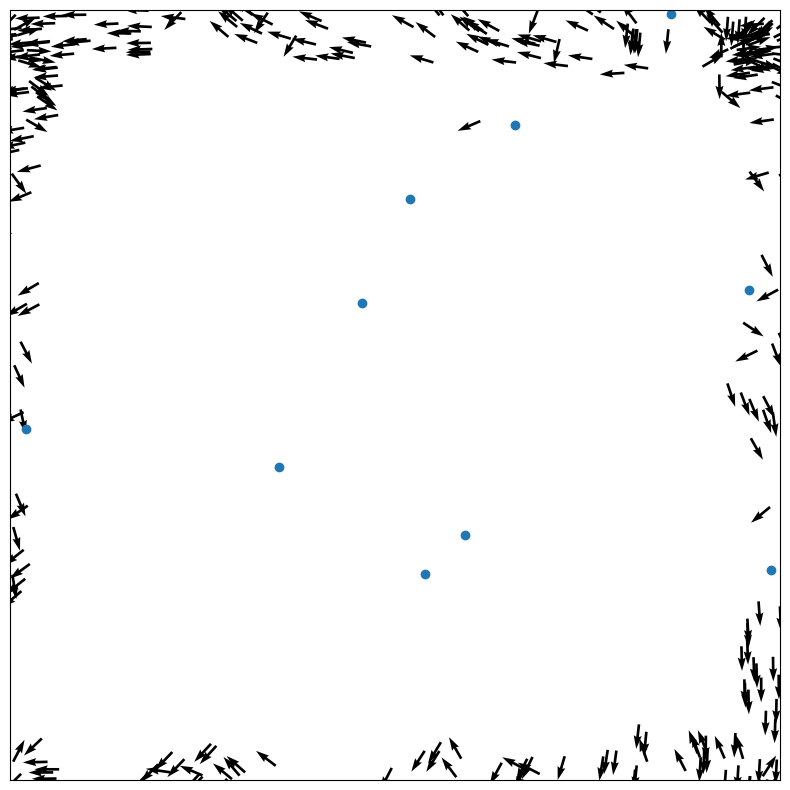

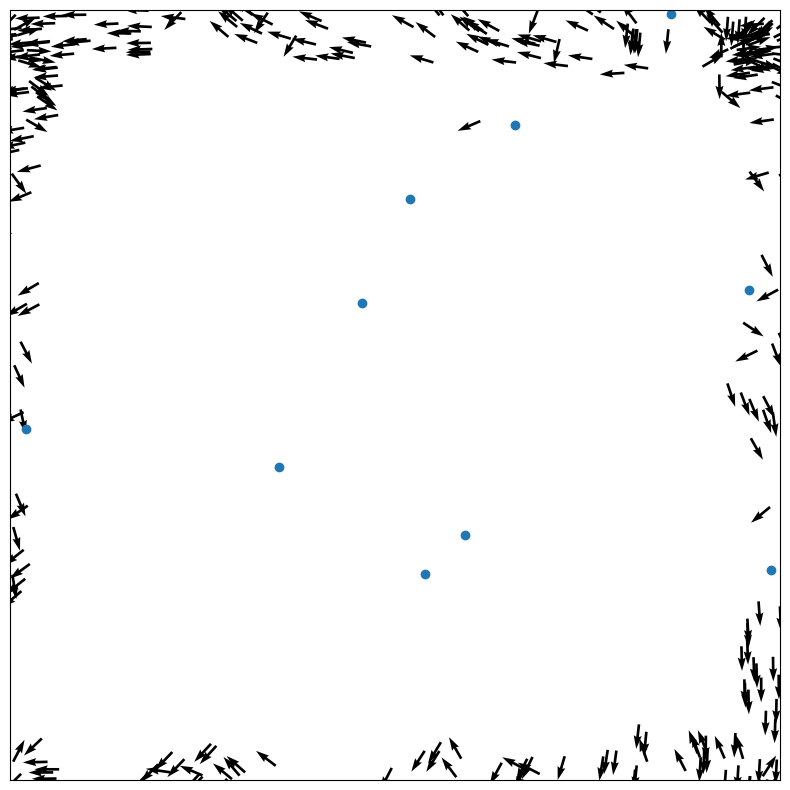

In [155]:

# set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N,L)

# do an initial plot and set up the axes
q = plt.quiver(x,y,vx,vy)
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

k=0
plt.scatter(x_o, y_o)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    k += dead_bird(x,y,x_o,y_o)
    x,y,vx,vy = step(x,y,vx,vy,dt)
    q = update_quiver(q,x,y,vx,vy)
    clear_output(wait=True)
    display(fig)
    plt.savefig('flock.pdf')

In [119]:
print('The number of birds who died (got too close to the obstacles) is '+str(k))

The number of birds who died (got too close to the obstacles) is 161
